In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

d:\Project\liveness_vit\notebook


In [2]:
import sys
sys.path.append("")

In [3]:
import torch 
import torch.nn as nn

from skimage import io
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

In [4]:
im_path = "image_test/faketwo.jpg"
model_path = "vit_base_patch16_224.augreg_in21k_ft_in1k"
image_size = 1024

In [5]:
def get_image(im_path,shape=image_size):
    img = io.imread(im_path)[:,:,:3]
    org_img = img.copy()
    img = A.Normalize()(image=img)["image"]
    norm_img = img.copy()
    img = np.transpose(img,(2,0,1))
    img = np.expand_dims(img,0)

    img = torch.tensor(img)
    img = nn.Upsample((shape,shape))(img)
    
    return img,norm_img, org_img

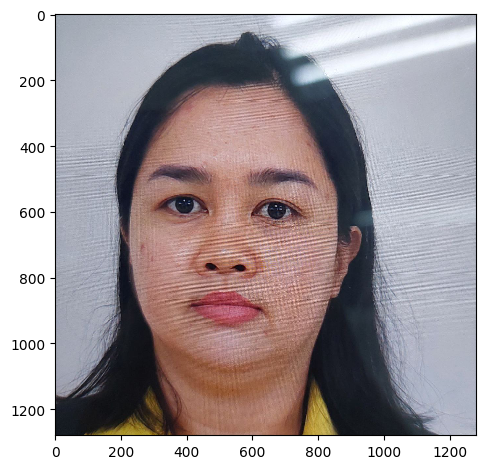

In [6]:
img,norm_img, org_img = get_image(im_path)
io.imshow(org_img)

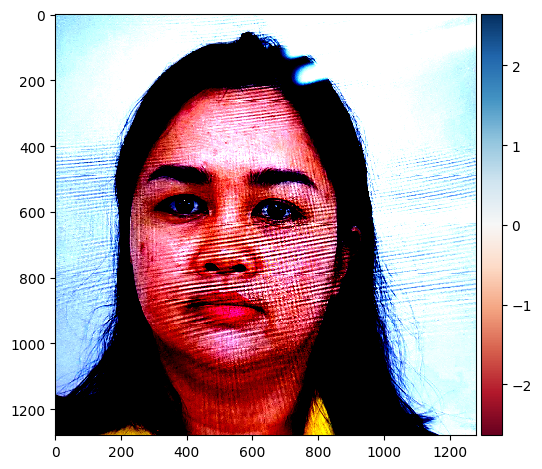

In [7]:
io.imshow(norm_img)

In [8]:
import timm
model = timm.create_model(model_path,img_size=image_size, dynamic_img_size=True,pretrained=True).cuda()

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_base_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.layers.pos_embed:Resized position embedding: (14, 14) to (64, 64).


In [9]:
outputs = {}
def get_outputs(name):
    def hook(model, input, output):
            outputs[name] = output.detach()
        
    return hook

In [10]:
model.cuda().blocks[-1].attn.q_norm.register_forward_hook(get_outputs('q'))
model.cuda().blocks[-1].attn.k_norm.register_forward_hook(get_outputs('k'))
# model.cuda().blocks[-1].attn.qkv.register_forward_hook(get_outputs('qkv',model.cuda().blocks[-1].attn))

model.cuda().blocks[-1].register_forward_hook(get_outputs('last_layer'))
model.cuda()(img.cuda())

c:\Users\Admin\anaconda3\envs\liveness\lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


tensor([[-2.9592e-01,  1.1866e+00,  3.5787e-01, -1.8036e+00, -6.0438e-01,
          4.4683e-02,  4.0632e-01, -3.1659e-01, -1.6783e+00, -6.9412e-01,
         -3.2882e+00, -1.7959e+00, -2.3235e+00, -8.9439e-01, -1.0596e+00,
         -1.5729e+00, -1.9938e+00, -1.8344e+00, -2.9150e+00, -1.6154e+00,
         -3.1475e+00, -1.0350e+00, -9.2827e-01, -5.1951e-01, -1.1479e+00,
         -1.6142e+00, -7.6251e-01, -8.8770e-01, -5.8468e-03, -2.6894e-02,
         -2.1749e+00, -8.5382e-02, -4.4415e-01,  7.1337e-01, -4.6173e-01,
         -1.7281e+00, -7.5696e-01, -1.8852e+00, -3.2549e-01, -1.7164e-01,
         -9.6645e-01, -1.3091e+00, -2.1233e+00, -5.5997e-01, -1.2968e+00,
          1.4126e-01, -2.7888e-01, -4.1294e-01,  1.2478e-01, -2.6455e+00,
         -1.7286e-01,  3.8081e-01, -1.5454e+00, -1.2990e+00, -2.0619e+00,
         -1.1486e+00, -2.4748e+00, -2.2937e+00, -1.1168e+00, -7.6346e-01,
         -4.8021e-01, -1.2555e+00, -1.6832e+00,  3.0131e-01, -3.1250e-01,
         -1.2220e+00, -1.3533e+00, -2.

In [11]:
outputs["attentions"] = outputs["q"] @ outputs["k"].transpose(-2, -1)

In [12]:
outputs["attentions"].shape ## B, num_heads, num_patches+1,num_patches+1

torch.Size([1, 12, 4097, 4097])

In [13]:
print(
"\n last_hidden_state",outputs["last_layer"].shape, 
"\n attentions last layer", outputs["attentions"].shape, 
)


 last_hidden_state torch.Size([1, 4097, 768]) 
 attentions last layer torch.Size([1, 12, 4097, 4097])


In [14]:
map_size = int(np.sqrt(4096))

## Visualizing Feature Vector Outputs patchwise based on mean

In [15]:
feature =  outputs["last_layer"] ## 1xnum_patches+1x768

In [16]:
feature_map = feature.mean(axis=-1) ## taking mean at feature axis ## [num_patches+1x]
feature_map = feature_map[:,1:] ## removing cls token ## [1,num_patches]


feature_map = feature_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

feature_map = nn.Upsample(size=(image_size,image_size))(feature_map)
print(feature_map.shape)

torch.Size([1, 1, 1024, 1024])


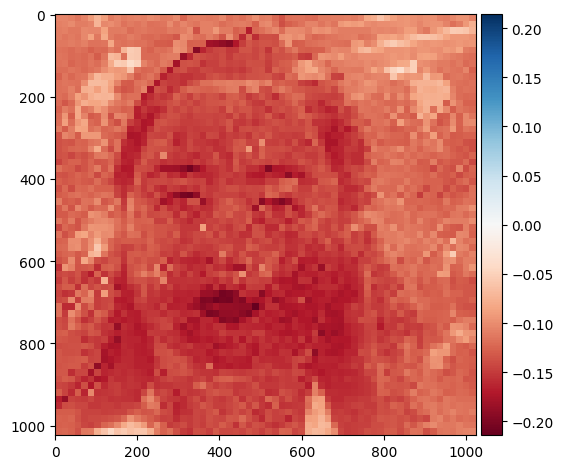

In [17]:
feature_map = feature_map[0,0,:,:].detach().cpu().numpy()

# feature_map = (feature_map-feature_map.min())/(feature_map.max()-feature_map.min())
io.imshow(feature_map)

## Visualizing Attentions Vector Outputs patchwise based on mean

In [18]:
attentions = outputs["attentions"] ## 1xnum_heads,num_patches+1x768
print(attentions.shape)

torch.Size([1, 12, 4097, 4097])


torch.Size([1, 1, 1024, 1024])


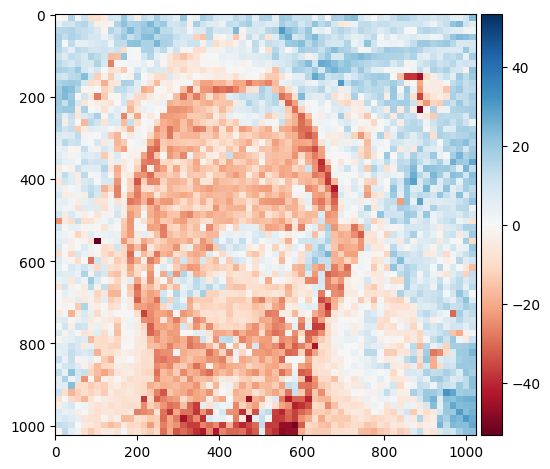

torch.Size([1, 1, 1024, 1024])


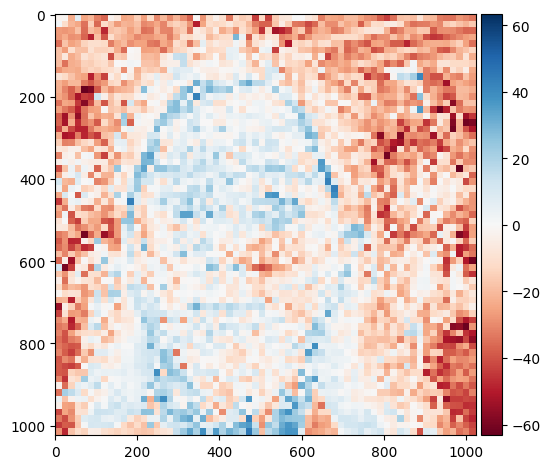

torch.Size([1, 1, 1024, 1024])


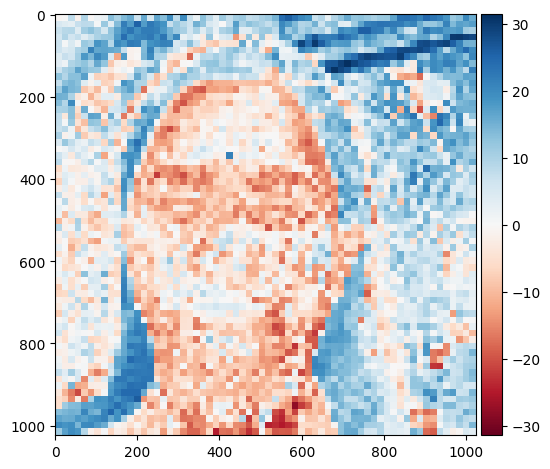

torch.Size([1, 1, 1024, 1024])


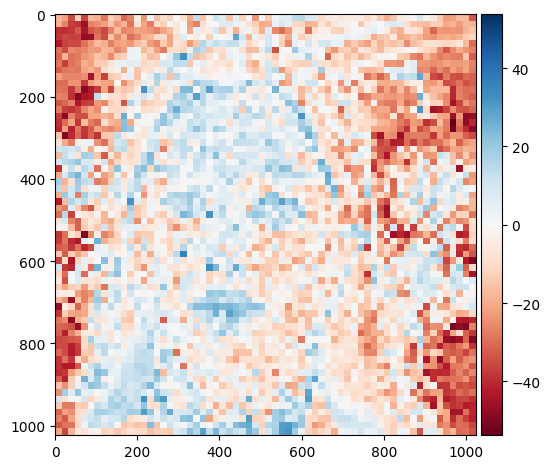

torch.Size([1, 1, 1024, 1024])


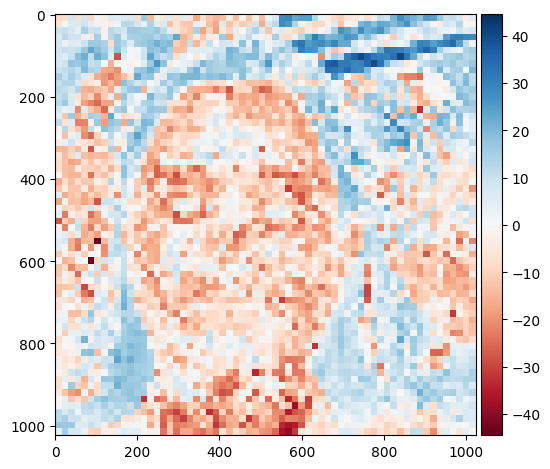

torch.Size([1, 1, 1024, 1024])


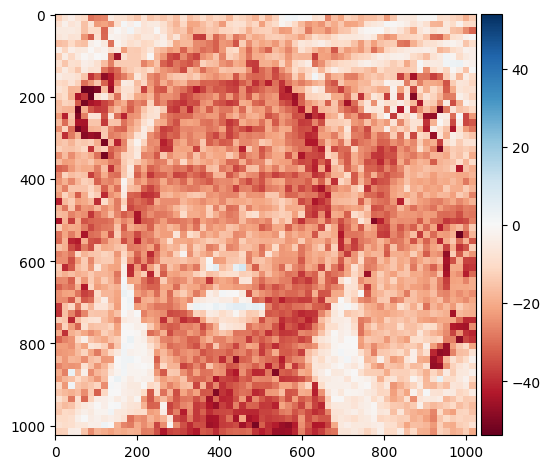

torch.Size([1, 1, 1024, 1024])


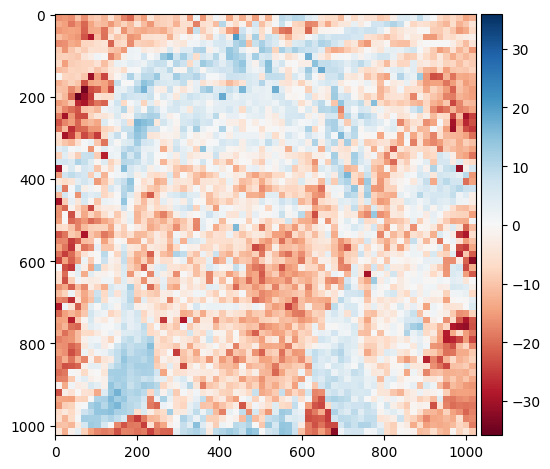

torch.Size([1, 1, 1024, 1024])


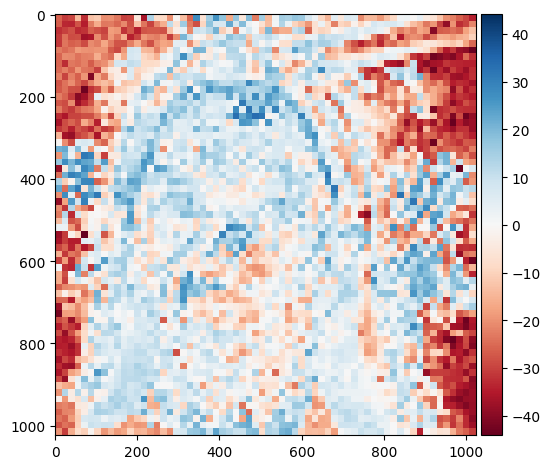

torch.Size([1, 1, 1024, 1024])


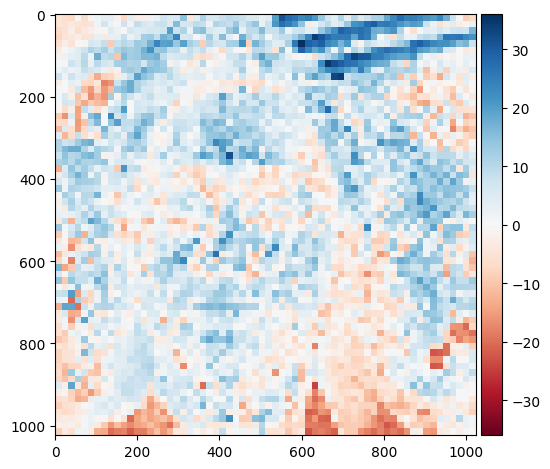

torch.Size([1, 1, 1024, 1024])


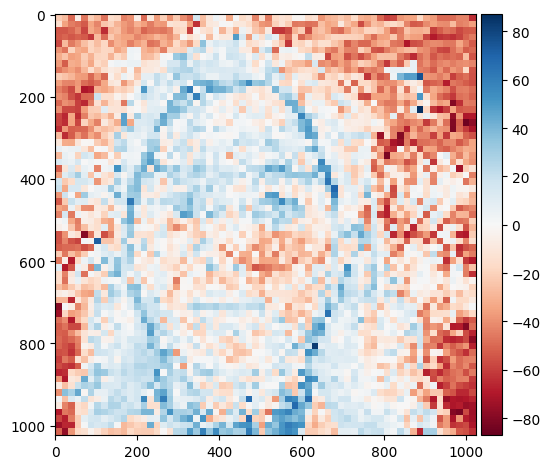

torch.Size([1, 1, 1024, 1024])


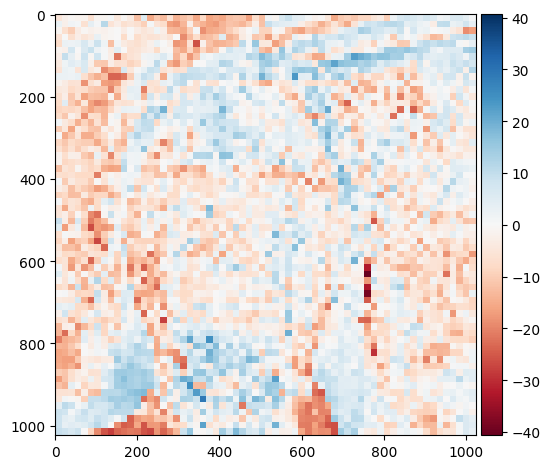

torch.Size([1, 1, 1024, 1024])


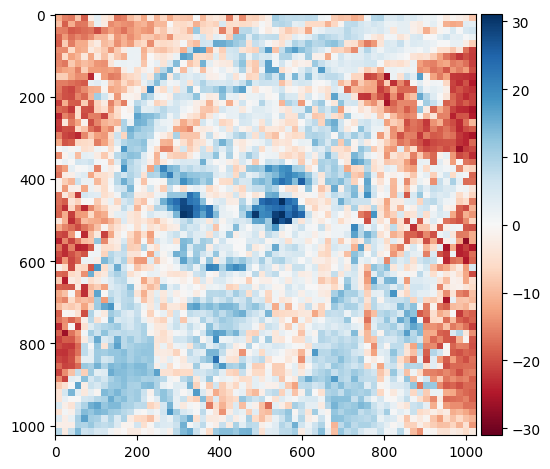

In [19]:
num_heads = attentions.shape[1]

for attention_head in range(num_heads):
    attentions_map = attentions[:,attention_head,:,0]
    attentions_map = attentions_map[:,1:] ## removing cls token ## [1,num_patches]
#     map_size = int(np.sqrt(4096))

    attentions_map = attentions_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

    attentions_map = nn.Upsample(size=(image_size,image_size))(attentions_map)
    print(attentions_map.shape)

    attentions_map = attentions_map[0,0,:,:].detach().cpu().numpy()

#     attentions_map = (attentions_map-attentions_map.min())/(attentions_map.max()-attentions_map.min())
    io.imshow(attentions_map)
    plt.show()
    

## Visualizing Attentions Vector Outputs patchwise based on mean of all heads

In [20]:
attentions = outputs["attentions"] ## 1xnum_patches+1x768
print(attentions.shape)

torch.Size([1, 12, 4097, 4097])


torch.Size([1, 1, 1024, 1024])


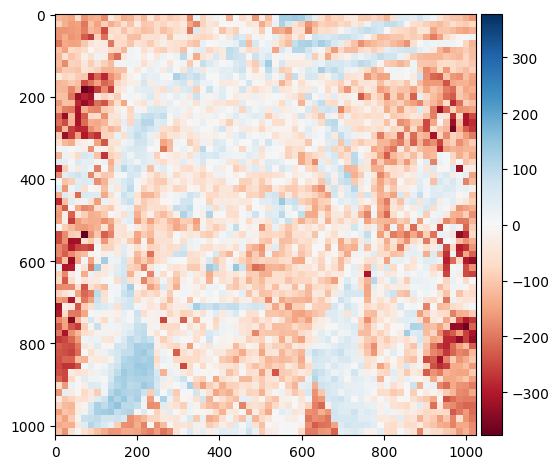

In [21]:
attentions_map = attentions.sum(axis=1)
attentions_map = attentions_map[:,:,0]
attentions_map = attentions_map[:,1:] ## removing cls token ## [1,num_patches]

attentions_map = attentions_map.view(1,1,map_size,map_size) ## adding channel axis for upsample

attentions_map = nn.Upsample(size=(1024,1024))(attentions_map)
print(attentions_map.shape)

attentions_map = attentions_map[0,0,:,:].detach().cpu().numpy()

#     attentions_map = (attentions_map-attentions_map.min())/(attentions_map.max()-attentions_map.min())
io.imshow(attentions_map)
plt.show()